# Assignment 2

The assignment 2 contains 3 questions and the due date is May 1 (Monday) 23:59PM.

## Question 1 Image Compression

In this question, you will work with images and apply KMeans for image compression, by reducing the number of colours that occur in an image to only those that are most common in that image.


### Question 1.1 (0 points)

To let you learn how Python work with images, plese complete this question.

### Black & white images

Each images represent a matrix where each pixel is an element of this matrix 
<img src="https://miro.medium.com/max/1386/1*bV7S0zACdidh11ikjYpLpQ.png">
The scale of colors is between 0 and 255 : 0 correspond to black and 255 to white

### Colored images
<img src="https://miro.medium.com/max/840/1*y0nV4cWk3KbzXSe9dIWL5g.jpeg">

Every color is a linear combinaison of primary colors : Red Green Blue <br/>
A colored image is somehow just the supperposition of three images : for each pixel with have three values




### Download images

We are using the famous [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) that consists of 60000 32x32 color images in 10 classes, with 6000 images per class. We need to donwload this dataset from tensorflow. If you have not installed tensorflow, please follow the [instllation guide](https://www.tensorflow.org/install) to get it or simply use Google colab for this assignment.




In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

By checking the shape, you will find the train set contains 50,000 images with the shape of (32, 32, 3) that indicates the image resolution with 3 color channels.

In [3]:
x_train.shape

(50000, 32, 32, 3)

You can visually check a random image:

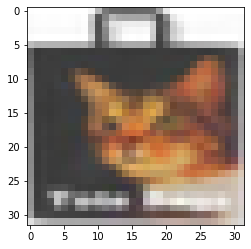

In [4]:
plt.imshow(x_train[3000])

We can also check the image at each of three channels:

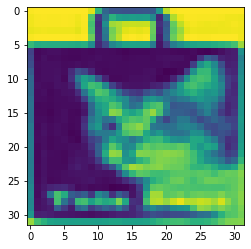

In [5]:
plt.imshow(x_train[3000][:, :, 0])

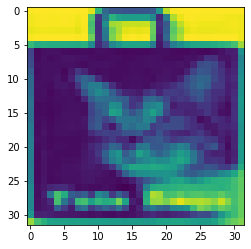

In [6]:
plt.imshow(x_train[3000][:, :, 1])

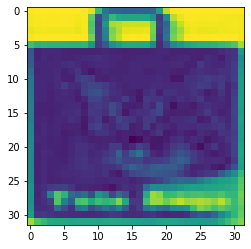

In [7]:
plt.imshow(x_train[3000][:, :, 2])

We can convert a color image as a greyscale image using the NTSC formula: 0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue. This formula closely represents the average person's relative perception of the brightness of red, green, and blue light.

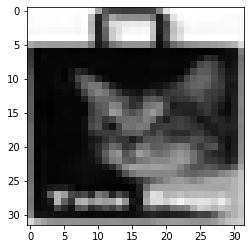

In [8]:
R, G, B = x_train[3000][:,:,0], x_train[3000][:,:,1], x_train[3000][:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.imshow(imgGray, cmap='gray')

### Question 1.2 (10 points)

Convert all color images in x_train into greyscale images and use the sklearn.decomposition.PCA to perform principal component analysis to the dataset to reduce dimensions to 256. Then, reconstruct images from its reduced representation. Choose a image and see how it goes before and after the PCA using imread method. Explain your findings.  

**Hint** You may need to use numpy's reshape method to change the representation of each image as a vector before performing PCA and reshape it back as an image before you are able to visualize it.

### Question 1.3 (10 points)

Now explain which number of principal components should be chosen using Elbow method if PCA reaches 90% threshold of explained variance. Use the obtained number of principal components to reduce the image dimensions and again compare the reconstructed images from the previous step. Expalin your findings.

### Question 1.4 (10 points)

Now build an image classifier of Logistic Regression (with default configuration) to predict the class of images using the original greyscale images and the compressed representations from PCA that explains 90% of variance. Use the 5-fold cross-validation to report the average macro-f1 test score (given this is a balanced dataset) and total fit time. Explain your findings.

Hint: y_train contains the uint8 value and cross-validate would not consider it as the label for classification. You need to convert the y_train into categorical values such that cross-validate would perform multi-class classification.

### Question 1.5 (15 points)

Now let's work with the color images (with 3 channels) and again compress one image, this time by reducing numbers of colors using K-means. You need to cluster pixel values into **32 clusters** and choose the "mean color" to replace all the pixels in each cluster by this mean color. Show the original color image of cat and the mean color image of the same one. Explain your findings. 

Hint: each color pixel is represented by a 3D (R,G,B) vector, and the image would have 32x32 pixels. So you could find the mean color from the centroids of 32 clusters and update the pixels of image with the mean color.

Hint2: Once you have replaced the pixel values with mean color, you need to explicitly convert it into **uint type** such s uint8, uint16, etc, because the image pixel values can only be represented as integers or fractions.

## Question 2 Nova SBE Wikipedia 


In this question, you will work with time-series forecasting of page views of [Nova SBE's Wikipedia page](https://en.wikipedia.org/wiki/Nova_School_of_Business_and_Economics)  

When you click 'View history', you should see the backend of the wiki page and you can further select 'Pageviews' to have the statistics of page views of this page. Let's select the page views from all times (July 2015 to April 2023) at monthly level from users only (we exclude robot/spider views) and here is the [link](https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2015-07&end=2022-07&pages=Nova_School_of_Business_and_Economics) that allows you to get it directly. You can choose to download the data as csv or JSON file to work on.


In [137]:
pageview = pd.read_csv('/Users/qiweihan/Downloads/pageviews.csv')
pageview

,Date,Nova School of Business and Economics
0,2015-07,614
1,2015-08,675
2,2015-09,753
3,2015-10,703
4,2015-11,652
...,...,...
80,2022-03,1394
81,2022-04,1267
82,2022-05,1231
83,2022-06,1372


In [138]:
pageview['Date'] = pd.to_datetime(pageview['Date'])
pageview.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

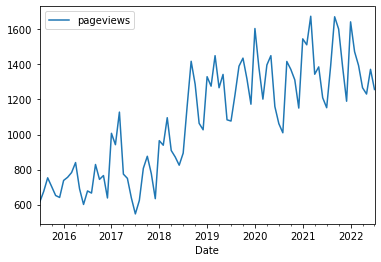

In [139]:
pageview.rename(columns={'Nova School of Business and Economics':'pageviews'}, inplace=True)
pageview.plot()

### Question 2.1 Ensure Stationarity (10 points)

We will perform time-series forecasting and we need to ensure stationarity first. Perform [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)and explain whether the pageview of wiki pages is stationary and would you be able to stationarize the data through first-order and second-order differencing (you can check the p-value and see if you achieve the statistical significance)?

Alternatively, you could also stationarize the pageview time series through deseasonlization. Perform seasonal decomposition using additive or multiplicative methods and explain whether you would achieve stationary time-series through seasonal decomposition?


### Question 2.2 Identify the hyperparameter (10 points)

Using the method from the previous section, we will preprocess the time series by deseasonalizing it (either additive or multiplicative) and identify the optimal hyperparameter of (p,d,q) for ARIMA model. Explain how would you find these hyperparameters. You could consider plotting autocorrelation and partial autocorrelation functions. 

### Question 2.3 Fit and forecast (10 points)

Now let's fit the ARIMA model using the identified hyperparameter of (p,d,q). Let's use the first 80% observations as the train set and remaining 20% observations as the test set 

Once you fit the model on the train set, you can make the forecast on the test set. Use the provided plot_forecast function to visulize the forecasted values and real values (together with 95% confidence interval). 

Lastly, report the mean absolute percentage error on the test set (you can use the sklearn implementation).

Hint: do not forget to add back the seasonality component to reconstruct the original pageview

## Question 3 Birds of a feather sing together


In this question, you will work with movie ratings to build a recommender system just like Netflix, Youtube, etc.


__Load the datasets in three different pandas dataframes `movies`, `tags` and `ratings`.__


In [27]:
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')


In [28]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [30]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Let's filter the ratings dataframe, to have only movies that have received a rating:

In [31]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]
movies.shape

(9724, 3)

### Question 3.1 (10 points) Content-based recommender system

We create a new feature called metadata, that merges all the text data information we have about a movie : the genre and the tags. So the merged dataframe should contain at least the following columns: *movieId, title and metadata*.

Then, construct the vectorized reprentation of metadata using sklearn's Countvectorizer to transform the metadata into vectors. Learn the latent matrix from the metadata vector using [truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) with 50 dimensions. With the generated latent matrix, identify the top 10 most relevant movies for **"Toy Story (1995)"** by calculating the cosine similairty and finding movies with the highest similarity score. 



### Question 3.2 (10 points) Collaborative filtering recommender system

Similarly, let's creat a latent matrix for ratings and also show the top 10 most relevant movies that receive similar ratings. 




### Question 3.3 (5 points) Hybrid recommender system

Similarly, let's build a hybrid recommender system and also show the top 10 most relevant movies that calculate the average measure of both content and collaborative.
